In [203]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import torch as th
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import datasets, tree
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [1068]:
def plot_roc(y, y_hats, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for y_hat, label in zip(y_hats, labels):
        auc = roc_auc_score(y, y_hat)
        fpr, tpr, thresh = roc_curve(y, y_hat)
        ax.plot(fpr, tpr, label=f'{label}; AUC={auc:.3f}', marker='o', markersize=1)
        # ax.step(fpr, tpr, where='mid', label=f'{label}; AUC={auc:.3f}', marker='o', markersize=1)
    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
    
def get_path_description(dts, X_train, sample_id):
    X_test = X_train[:,0].numpy().reshape(-1,1)
    clf = dts[0]
    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)
    
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=X_test[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )
        
def compare_histograms(X_1, X_2, x1_labels, x2_labels, logx=False):
    fig, axs = plt.subplots(X_1.shape[1], 1, figsize=(4, 4*X_1.shape[1]))
    kwargs = dict(alpha=0.5, density=True)
    if logx:
        X_1 = np.log10(X_1)
        X_2 = np.log10(X_2)

    X = np.vstack([X_1, X_2])
    if not hasattr(axs, '__iter__'):
        axs = [axs]
    for idx, ax in enumerate(axs):
        bins = np.linspace(X[:,idx].min(), X[:,idx].max(), 50)
        _, _, _ = ax.hist(X_1[:,idx], bins=bins, label=f'{"log " if logx else ""}X_1: {x1_labels[idx]}', **kwargs)
        _, _, _ = ax.hist(X_2[:,idx], bins=bins, label=f'{"log " if logx else ""}X_2: {x2_labels[idx]}', **kwargs)
        ax.legend()

In [470]:
class Distribution():
    supported = ['normal', 'gamma', 'lognormal']
    def __init__(self, family, parms):
        self.family = family # str
        self.name = self.family.lower()
        assert self.name in self.supported, f'{family} not supported'
        
        self.parms = parms # dict
        err_msg = 'Missing paramater {} for {} family!'
        if self.name=='normal':
            parm_names = ['loc', 'scale']
            for p in parm_names:
                assert p in self.parms, err_msg.format(p, self.family)
        elif self.name=='gamma':
            parm_names = ['shape', 'scale']
            for p in parm_names:
                assert p in self.parms, err_msg.format(p, self.family)
        elif self.name=='lognormal':
            parm_names = ['mean', 'sigma']
            for p in parm_names:
                assert p in self.parms, err_msg.format(p, self.family)
        
    def __str__(self):
        parms_str = ''
        for k, v in self.parms.items():
            parms_str += f'{k}={v:.3f}, '
        return f'{self.family}({parms_str[:-2]})'
    
    def __repr__(self):
        return self.__str__()
    
    def generate(self, rng, N):
        generator = getattr(rng, self.name)
        return generator(**self.parms, size=N)
        

class ToyDataGenerator():
    def __init__(self):
        self.rng = default_rng()
        self.distributions = list()
        
    def add_normal(self, loc, scale):
        """
        Commonly used for values coming from additive processes
        
        Args
        ------------
        loc: float
            Mean value
        scale: float
            Standard deviation
        """
        self.distributions.append(Distribution('Normal', dict(loc=loc, scale=scale)))
    
    def add_gamma(self, k, theta):
        """
        Commonly used for waiting times
        
        Args
        ------------
        k: float
            Shape parameter.  Skewness = 1/sqrt(k)
        theta: float
            Scale parameter.
        """
        self.distributions.append(Distribution('Gamma', dict(shape=k, scale=theta)))
        
    def add_lognormal(self, mu, sigma):
        """
        Commonly used for waiting times
        
        Args
        ------------
        mu: float
            Mean
        sigma: float
            Standard deviation
        """
        self.distributions.append(Distribution('LogNormal', dict(mean=mu, sigma=sigma)))
        
    def generate(self, N):
        vals = list()
        for dist in self.distributions:
            vals.append(dist.generate(self.rng, N).reshape(-1,1))
        return np.hstack(vals)

In [471]:
gen = ToyDataGenerator()
gen.add_normal(1, 1)
gen.add_gamma(1, 1)
gen.add_gamma(1, 2)
gen.add_lognormal(1, 1)

In [472]:
X = gen.generate(5000)

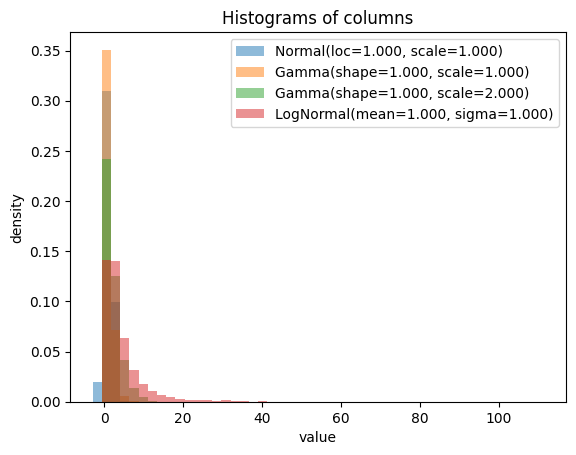

In [473]:
fig, ax = plt.subplots()
bins = np.linspace(X.min(), X.max(), 50)
kwargs = dict(alpha=0.5, density=True)
for idx in range(X.shape[1]):
    _, _, _ = ax.hist(X[:,idx], bins=bins, label=gen.distributions[idx], **kwargs)

ax.set(xlabel='value', ylabel='density', title='Histograms of columns')
_ = ax.legend()

## Make ML classification datasets
- This shows it well:  
  - `c1_generator.add_lognormal(1, 1)`, `c2_generator.add_lognormal(1, 2)`
  

In [1486]:
c1_generator = ToyDataGenerator()
c2_generator = ToyDataGenerator()

# normal - different mean, same std
# c1_generator.add_normal(1, 1)
# c2_generator.add_normal(2, 1)

# normal - same mean, different std
# c1_generator.add_normal(1, 1)
# c2_generator.add_normal(1, 2)

# normal - different mean, different std
c1_generator.add_normal(1, 1)
c2_generator.add_normal(2, 2)

# log-normal - same mean, different std
# c1_generator.add_lognormal(1, 1)
# c2_generator.add_lognormal(1, 2)

# log-normal - different mean, same std
# c1_generator.add_lognormal(1, 3)
# c2_generator.add_lognormal(2, 3)

# gamma - double sided
# c1_generator.add_gamma(5, 3)
# c2_generator.add_gamma(2, 8)

In [1487]:
N_1, N_2 = 10000, 10000
X_1 = c1_generator.generate(N_1)
X_2 = c2_generator.generate(N_2)
idx = default_rng().permutation(np.arange(N_1+N_2))

X = np.vstack([X_1, X_2])[idx,:]
y = np.concatenate([np.zeros(N_1), np.ones(N_2)])[idx]

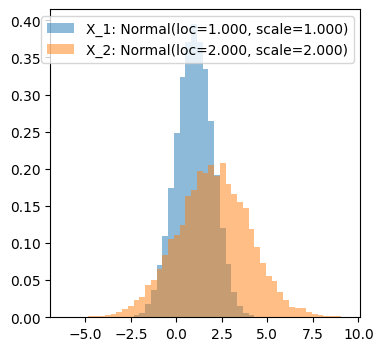

In [1488]:
compare_histograms(X_1, X_2, c1_generator.distributions, c2_generator.distributions)

In [1489]:
X = th.tensor(X).float()
y = th.tensor(y)

In [1490]:
N_train = int(X.shape[0]*0.8)
X_train = X[:N_train,:]
y_train = y[:N_train].float()
X_test = X[N_train:,:]
y_test = y[N_train:].float()

In [1491]:
if X.shape[1] >= 2:
    pca = PCA(n_components=2)
    pca.fit(X)
    fig, ax = plt.subplots()
    ax.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=y, s=1)
    _ = ax.grid()

## Random Forest baseline

In [1492]:
from sklearn.ensemble import RandomForestClassifier

In [1493]:
# clf_rf = RandomForestClassifier(max_leaf_nodes=10, n_estimators=10)
clf_rf = RandomForestClassifier(n_estimators=300, max_depth=8)

In [1494]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=300)

In [1495]:
y_hat_rf = clf_rf.predict_proba(X_test)[:,1]

## Neural networks

In [1496]:
def train(model, X_train, y_train, X_test, y_test, epochs=200, stop_criteria=5):
    opt = optim.Adam(model.parameters(), lr=0.01)
    train_losses = list()
    test_losses = list()
    min_test_ = 1e8
    es_counter = 0
    for e in range(epochs):
        opt.zero_grad()
        logits = model(X_train)
        loss = F.binary_cross_entropy_with_logits(logits.flatten(), y_train.float())
        loss.backward()
        opt.step()
        
        train_losses.append(loss.item())
        with th.no_grad():
            test_losses.append(
                F.binary_cross_entropy_with_logits(model(X_test).flatten(), y_test.float()).item()
            )
            if test_losses[-1]<min_test_:
                min_test_ = test_losses[-1]
                es_counter = 0
            else:
                es_counter += 1
                
        if es_counter > stop_criteria:
            print(f"Early stopping at epoch {e}")
            break
    return train_losses, test_losses, model(X_test).flatten().sigmoid().detach().numpy()

def plot_losses(train_losses, test_losses):
    fig, ax = plt.subplots()
    ax.plot(train_losses, label='Train')
    ax.plot(test_losses, label='Test')
    ax.grid()
    ax.legend()

In [1497]:
N_epochs = 800
es_criteria = 5

### Raw features

In [1498]:
model_raw = nn.Linear(X.shape[1], 1)

In [1499]:
train_losses, test_losses, y_hat_raw = train(model_raw, X_train, y_train, X_test, y_test, N_epochs, stop_criteria=es_criteria)

Early stopping at epoch 268


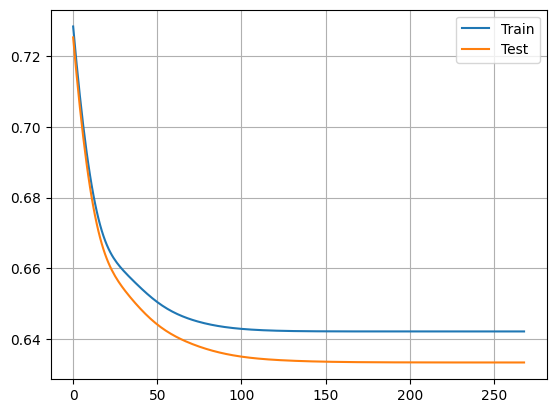

In [1500]:
plot_losses(train_losses, test_losses)

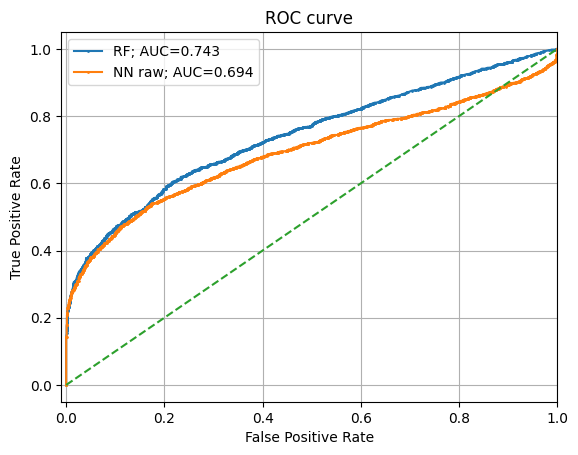

In [1501]:
plot_roc(y_test,[y_hat_rf, y_hat_raw], ['RF', 'NN raw'])

### Standard scaling methods

In [1502]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

#### all StandardScalar

In [1503]:
ss = StandardScaler()
X_train_ss = th.tensor(ss.fit_transform(X_train)).float()
X_test_ss = th.tensor(ss.transform(X_test)).float()

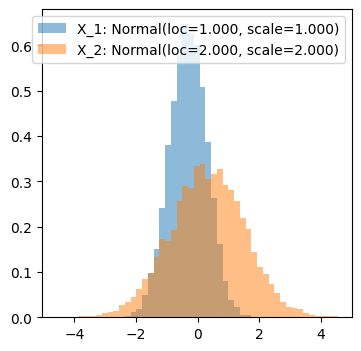

In [1504]:
compare_histograms(X_train_ss[y_train==0], X_train_ss[y_train==1], c1_generator.distributions, c2_generator.distributions)

In [1505]:
model_ss = nn.Linear(X.shape[1], 1)

In [1506]:
train_losses_ss, test_losses_ss, y_hat_ss = train(model_ss, X_train_ss, y_train, X_test_ss, y_test, N_epochs, stop_criteria=es_criteria)

Early stopping at epoch 18


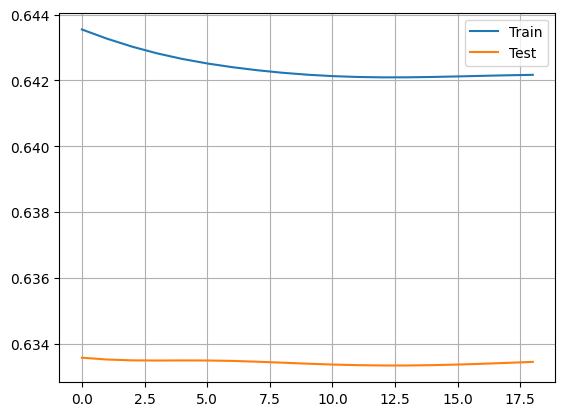

In [1507]:
plot_losses(train_losses_ss, test_losses_ss)

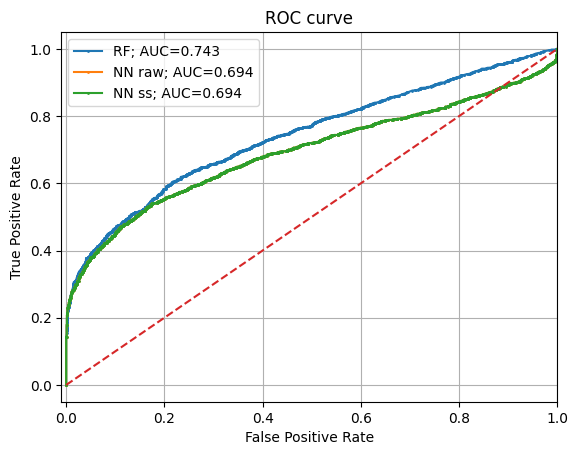

In [1508]:
plot_roc(y_test,[y_hat_rf, y_hat_raw, y_hat_ss], ['RF', 'NN raw', 'NN ss'])

#### all QuantileTransformer

In [1509]:
qt = QuantileTransformer(output_distribution='normal')
X_train_qt = th.tensor(qt.fit_transform(X_train)).float()
X_test_qt = th.tensor(qt.transform(X_test)).float()

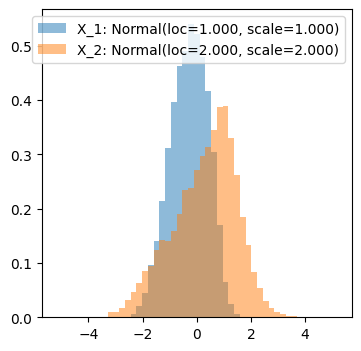

In [1510]:
compare_histograms(X_train_qt[y_train==0], X_train_qt[y_train==1], c1_generator.distributions, c2_generator.distributions)

In [1511]:
model_qt = nn.Linear(X.shape[1], 1)

In [1512]:
train_losses_qt, test_losses_qt, y_hat_qt = train(model_qt, X_train_qt, y_train, X_test_qt, y_test, N_epochs, stop_criteria=es_criteria)

Early stopping at epoch 271


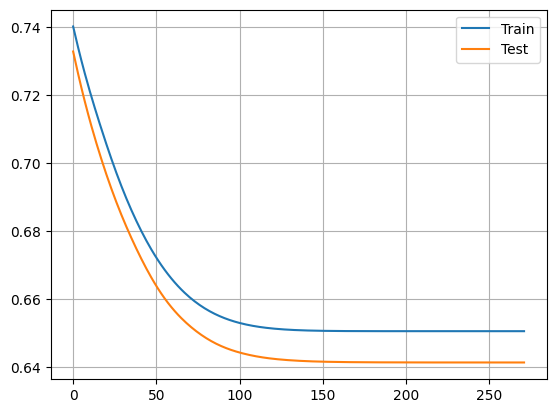

In [1513]:
plot_losses(train_losses_qt, test_losses_qt)

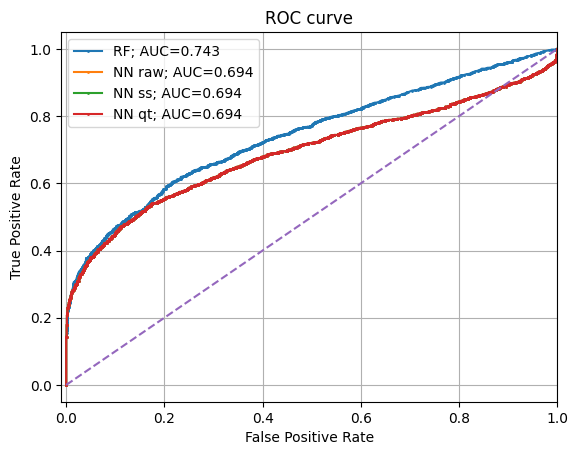

In [1514]:
plot_roc(y_test,[y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt], ['RF', 'NN raw', 'NN ss', 'NN qt'])

#### AutoGluon logic
i.e., QuantileTransformer if skew > 0.99

In [1515]:
from scipy.stats import skew

In [1516]:
skew_mask = np.array([skew(X_train[:,idx])>0.99 for idx in range(X_train.shape[1])])

In [1517]:
skew_mask.sum()

0

 No skewed distributions, so same as StandardScaler

#### Bucketize
Use equally-spaced bins

In [1518]:
from sklearn.preprocessing import OneHotEncoder

In [1519]:
X_train_bus = list()
X_test_bus = list()
for idx in range(X_train.shape[1]):
    bins = np.linspace(X_train[:,idx].min(), X_train[:,idx].max(), 10)
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(np.digitize(X_train[:,idx], bins).reshape(-1, 1))
    X_train_bus.append(th.tensor(ohe.transform(np.digitize(X_train[:,idx], bins).reshape(-1, 1))).float())
    X_test_bus.append(th.tensor(ohe.transform(np.digitize(X_test[:,idx], bins).reshape(-1, 1))).float())
X_train_bu = th.cat(X_train_bus, dim=1)
X_test_bu = th.cat(X_test_bus, dim=1)

In [1520]:
bins

array([-6.13679075, -4.44967609, -2.76256143, -1.07544676,  0.6116679 ,
        2.29878256,  3.98589722,  5.67301189,  7.36012655,  9.04724121])

In [1521]:
X_train_bu.sum(dim=0).int().numpy()

array([   8,   68,  581, 4025, 6952, 3074, 1041,  220,   30,    1],
      dtype=int32)

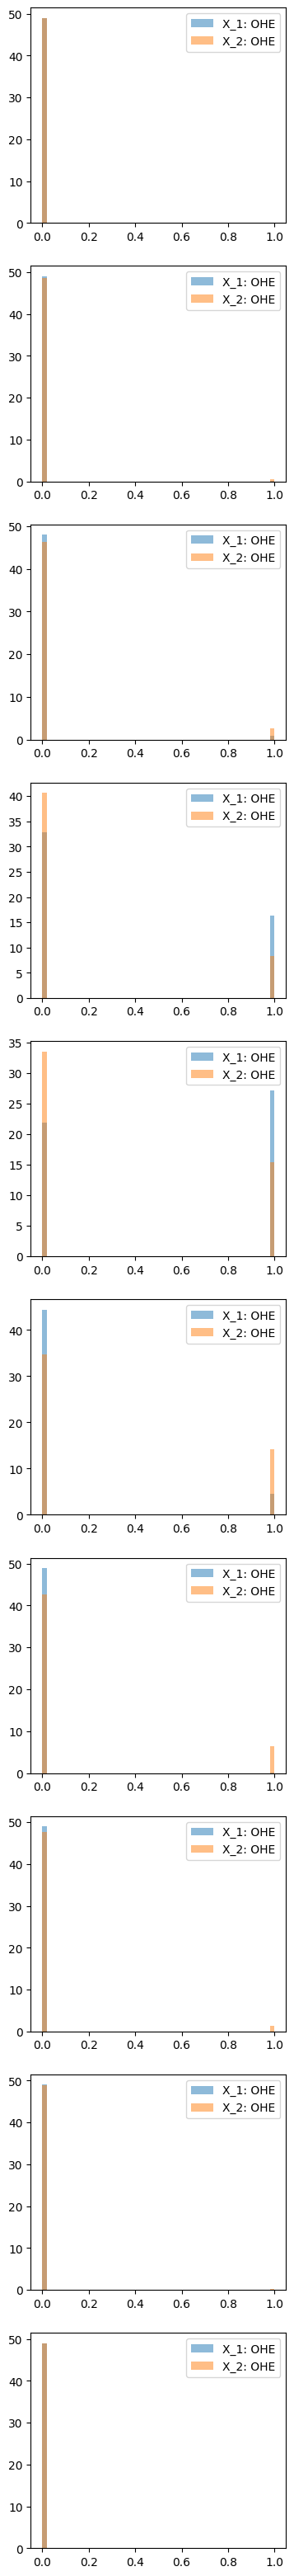

In [1522]:
compare_histograms(X_train_bu[y_train==0], X_train_bu[y_train==1], ['OHE']*10, ['OHE']*10)

In [1523]:
X_train.shape, X_train_bu.shape

(torch.Size([16000, 1]), torch.Size([16000, 10]))

In [1524]:
model_bu = nn.Linear(X_train_bu.shape[1], 1)

In [1525]:
train_losses_bu, test_losses_bu, y_hat_bu = train(model_bu, X_train_bu, y_train, X_test_bu, y_test, N_epochs, stop_criteria=es_criteria)

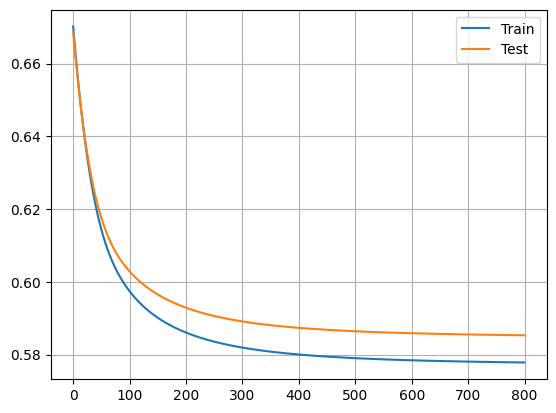

In [1526]:
plot_losses(train_losses_bu, test_losses_bu)

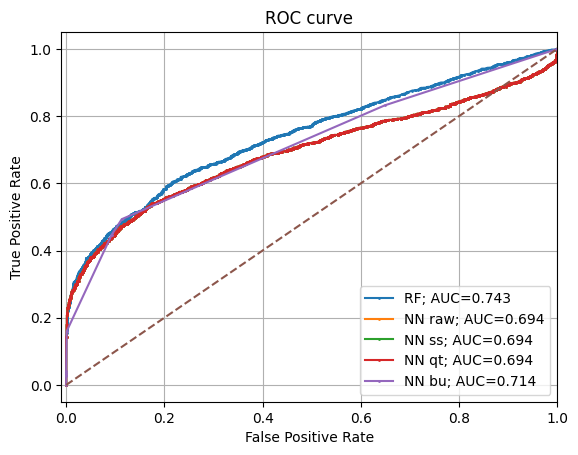

In [1527]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_bu], 
    ['RF', 'NN raw', 'NN ss', 'NN qt', 'NN bu']
)

## Map numeric to decision tree leafs

In [1528]:
max_splits = 10
dts = list()
les = list()
X_train_dt = th.zeros_like(X_train).long()
X_test_dt = th.zeros_like(X_test).long()
for idx in range(X_train.shape[1]):
    dtc = DecisionTreeClassifier(max_leaf_nodes=max_splits)
    dtc.fit(X_train[:,idx].reshape((-1,1)), y_train)
    dts.append(dtc)
    le = LabelEncoder()
    X_train_dt[:,idx] = th.tensor(le.fit_transform(dtc.apply(X_train[:,idx].reshape((-1,1))))).long()
    X_test_dt[:,idx] = th.tensor(le.transform(dtc.apply(X_test[:,idx].reshape((-1,1))))).long()
    les.append(le)
    
assert X_train.shape==X_train_dt.shape

### Understand trees

In [1529]:
# Note that these node IDs are not label encoded, as X_train_dt/X_test_dt are
get_path_description(dts, X_train, sample_id=227)

Rules used to predict sample 227:

decision node 0 : (X_test[227, 0] = 0.511763334274292) <= 2.592095732688904)
decision node 1 : (X_test[227, 0] = 0.511763334274292) > -1.2007938623428345)
decision node 4 : (X_test[227, 0] = 0.511763334274292) <= 1.7757406830787659)
decision node 5 : (X_test[227, 0] = 0.511763334274292) > -0.24916575849056244)
decision node 10 : (X_test[227, 0] = 0.511763334274292) <= 1.3104850053787231)


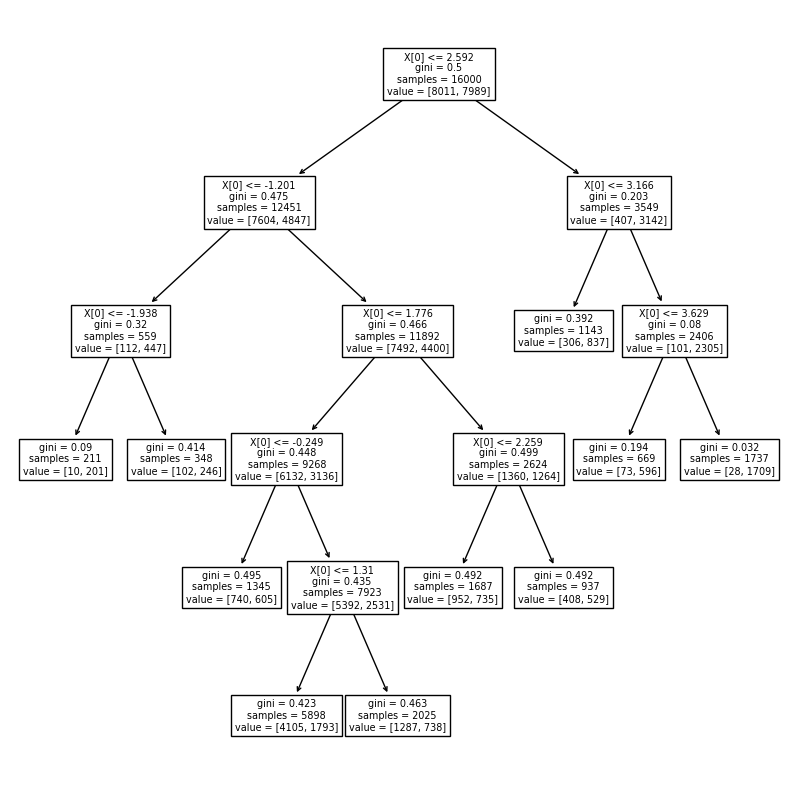

In [1530]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = tree.plot_tree(dts[0], ax=ax)

### Analyze Impurity Metrics
For each feature tree, calculate the weighted average impurity observed in each leaf node, where the weight is the number of training samples in the node.  See how this relates to single-feature AUC

In [1531]:
impurities = list()
impurities_mean = list()
for idx, dt in enumerate(dts):
    t = dt.tree_
    impurities.append(t.impurity[t.feature<0]*t.n_node_samples[t.feature<0])
    impurities_mean.append(impurities[-1].mean())

In [1532]:
aucs = list()
for idx in range(X.shape[1]):
    auc = roc_auc_score(y_train, X_train[:,idx])
    aucs.append(max(auc, 1-auc))

In [1533]:
# Features rated by their impurity reduction (best to worst)
np.argsort(impurities_mean)

array([0])

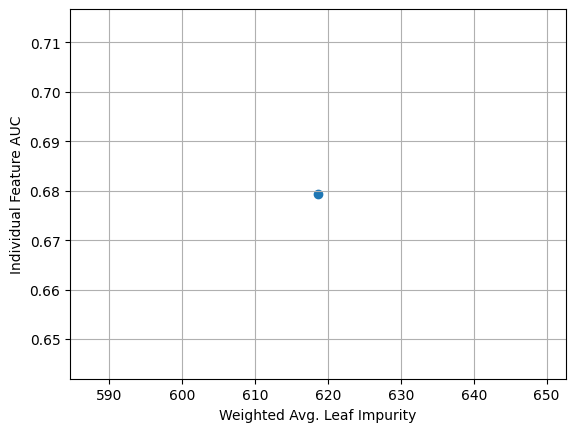

In [1534]:
fig, ax = plt.subplots()
ax.scatter(impurities_mean, aucs)
ax.set(xlabel='Weighted Avg. Leaf Impurity', ylabel='Individual Feature AUC')
ax.grid()

In [1535]:
class NumericEmbedding(nn.Module):
    def __init__(self, n_uniques, h_dim, agg_type='concat'):
        super().__init__()
        
        self.embeds = nn.ModuleList()
        for n_unique in n_uniques:
            self.embeds.append(
                nn.Embedding(n_unique, h_dim)
            )
        assert agg_type in ['concat', 'sum', 'mean']
        self.agg_type = agg_type
    
    def forward(self, X):
        hs = list()
        for idx, embed in enumerate(self.embeds):
            hs.append(embed(X[:,idx]))
        
        if self.agg_type=='concat':
            return th.hstack(hs)
        elif self.agg_type=='sum':
            return th.stack(hs, dim=2).sum(dim=2).squeeze()
        elif self.agg_type=='mean':
            return th.stack(hs, dim=2).mean(dim=2).squeeze()

In [1536]:
# topN = np.argsort(impurities_mean)
topN = np.arange(len(impurities_mean))
topN

array([0])

In [1537]:
# plot_roc(y_test, [-X_test[:,81]], ['feat 81'])

In [1538]:
# plot_roc(y_test, [X_test[:,161]], ['feat 161'])

In [1539]:
X_t_train = X_train_dt[:, topN]
X_t_test = X_test_dt[:, topN]

In [1540]:
n_uniques = (X_t_train.max(dim=0)[0]+1).numpy()

In [1541]:
embed_dim = 1
# model = nn.Sequential(NumericEmbedding(n_uniques, 1, 'concat'), nn.Linear(len(topN), 1))
model_dt = nn.Sequential(NumericEmbedding(n_uniques, embed_dim, 'concat'), nn.Linear(n_uniques.shape[0]*embed_dim, 1))
# model = nn.Sequential(NumericEmbedding(n_uniques, 8, 'mean'), nn.Linear(8, 1))

In [1542]:
sum([p.numel() for p in model_dt.parameters()])

12

In [1543]:
train_losses_dt, test_losses_dt, y_hat_dt = train(model_dt, X_t_train, y_train, X_t_test, y_test, N_epochs, stop_criteria=es_criteria)

Early stopping at epoch 232


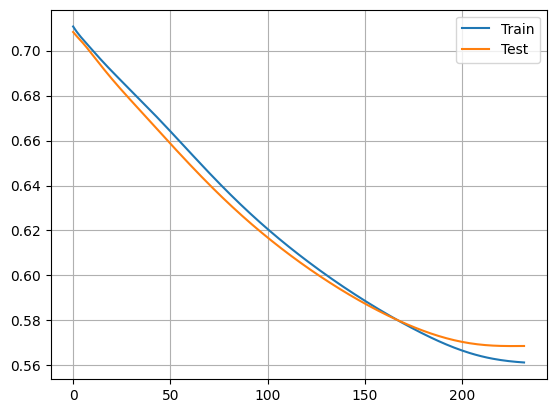

In [1544]:
plot_losses(train_losses_dt, test_losses_dt)

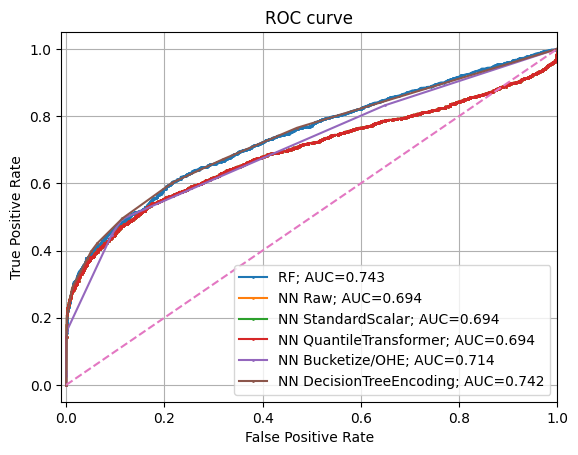

In [1545]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_bu, y_hat_dt],
    ['RF', 'NN Raw', 'NN StandardScalar', 'NN QuantileTransformer', 'NN Bucketize/OHE', 'NN DecisionTreeEncoding'],
    # x_max=0.1,
)

#### Visualize embeddings

In [1546]:
with th.no_grad():
    X_embed_train = model_dt[0](X_t_train).numpy()
    X_embed_test = model_dt[0](X_t_test).numpy()

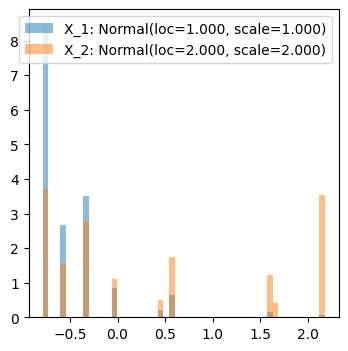

In [1547]:
compare_histograms(X_embed_train[y_train==0], X_embed_train[y_train==1], c1_generator.distributions, c2_generator.distributions)

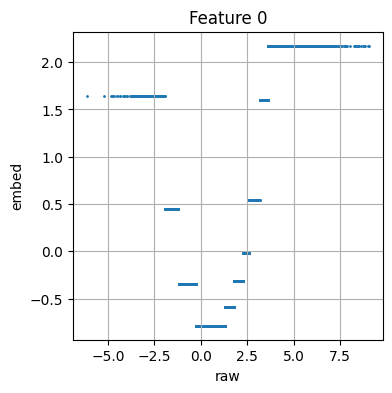

In [1548]:
#Raw vs learned
fig, axs = plt.subplots(X_embed_train.shape[1], 1, figsize=(4*X_embed_train.shape[1], 4))
if not hasattr(axs, '__iter__'):
    axs = [axs]

for idx, ax in enumerate(axs):
    _ = ax.scatter(X_train[:, idx], X_embed_train[:, idx], s=1)
    ax.set(xlabel='raw', ylabel='embed', title=f'Feature {idx}')
    _ = ax.grid()

In [1549]:
if X_embed_train.shape[1] >= 2:
    pca = PCA(n_components=2)
    pca.fit(X_embed_train)
    fig, ax = plt.subplots()
    ax.scatter(pca.transform(X_embed_test)[:,0], pca.transform(X_embed_test)[:,1], c=y_test, s=1)
    _ = ax.grid()